In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import layers, models, callbacks

In [2]:
# Load the dataset
df = pd.read_csv("merged_weather_pm25.csv")  # replace with your filename


In [3]:
# Drop non-numeric or unhelpful columns (like name, icon, preciptype)
df = df.drop(columns=["name"])

# Drop rows with missing values
df.dropna(inplace=True)

In [4]:
df.head()

,date,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,pm25
0,2024-01-01,76.2,60.6,67.1,76.2,60.6,67.1,60.7,80.7,0.0,...,304.2,1015.6,14.3,1.2,157.8,13.6,7,10,0.67,249
1,2024-01-02,71.7,58.9,63.6,71.7,58.9,63.6,57.9,82.2,0.0,...,312.7,1015.9,18.5,1.2,147.6,12.7,6,10,0.70,256
2,2024-01-03,73.4,59.0,63.8,73.4,59.0,63.8,57.9,81.8,0.0,...,353.6,1015.8,39.2,1.3,169.6,14.7,7,10,0.73,225
3,2024-01-04,75.4,57.2,65.1,75.4,57.2,65.1,59.2,82.1,0.0,...,79.3,1015.4,29.4,1.0,167.6,14.6,7,10,0.75,268
4,2024-01-05,71.2,57.2,63.6,71.2,57.2,63.6,59.7,87.6,0.0,...,97.9,1016.2,39.8,0.9,181.6,15.5,7,10,0.80,226


In [5]:
dates = df["date"]

In [6]:
X = df.drop(columns=["pm25",'date'])  
y = df["pm25"]


In [7]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
# Reshape for CNN input: (samples, features, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    # First Conv1D block
    layers.Conv1D(
        64, kernel_size=3, activation='relu', 
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train.shape[1], 1)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Second Conv1D block
    layers.Conv1D(
        32, kernel_size=3, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Dense layers
    layers.Flatten(),
    layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.Dropout(0.4),
    
    layers.Dense(1)  # Regression output
])

In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 20, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 32)            6176      
                                                                 
 batch_normalization_1 (Batc  (None, 18, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 18, 32)            0

In [13]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [14]:
# Train
history = model.fit(X_train, y_train, epochs=200, batch_size=4, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/200
68/68 [==============================] - 5s 15ms/step - loss: 30831.0176 - mae: 163.1556 - val_loss: 29984.0605 - val_mae: 160.1649
Epoch 2/200
68/68 [==============================] - 1s 10ms/step - loss: 11573.7725 - mae: 92.8905 - val_loss: 10374.3301 - val_mae: 85.9038
Epoch 3/200
68/68 [==============================] - 1s 10ms/step - loss: 3210.9778 - mae: 43.3376 - val_loss: 5858.4336 - val_mae: 61.9144
Epoch 4/200
68/68 [==============================] - 1s 9ms/step - loss: 2492.0786 - mae: 37.7787 - val_loss: 3510.3923 - val_mae: 46.8213
Epoch 5/200
68/68 [==============================] - 1s 10ms/step - loss: 2477.9546 - mae: 37.7142 - val_loss: 2721.6135 - val_mae: 40.6775
Epoch 6/200
68/68 [==============================] - 1s 10ms/step - loss: 2122.7559 - mae: 34.3954 - val_loss: 2083.4299 - val_mae: 36.2189
Epoch 7/200
68/68 [==============================] - 1s 10ms/step - loss: 1966.8605 - mae: 34.2251 - val_loss: 1642.2191 - val_mae: 30.8669
Epoch 8/200
68/

3/3 [==============================] - 0s 50ms/step


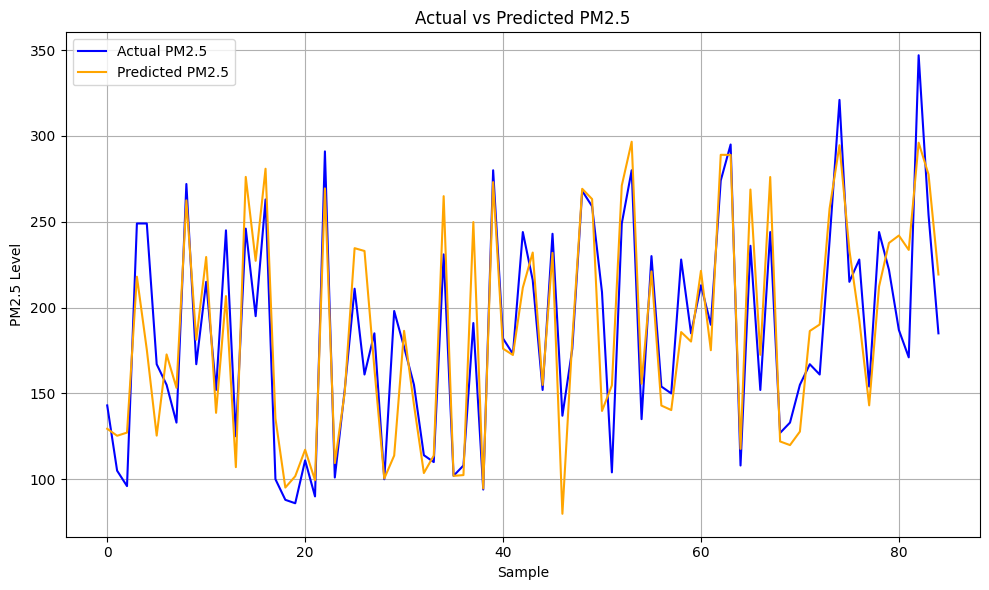

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual PM2.5", color='blue')
plt.plot(y_pred, label="Predicted PM2.5", color='orange')
plt.title("Actual vs Predicted PM2.5")
plt.xlabel("Sample")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"📉 MAE (Mean Absolute Error): {mae:.2f}")
print(f"📈 MSE (Mean Squared Error): {mse:.2f}")


📉 MAE (Mean Absolute Error): 22.28
📈 MSE (Mean Squared Error): 842.99


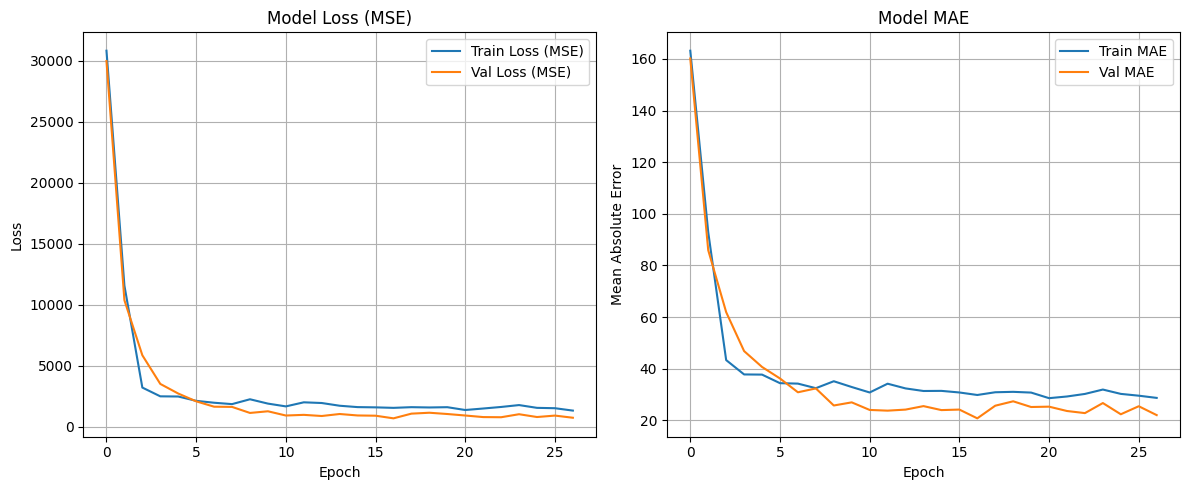

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
